In [374]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [375]:
num_input = 4
num_qubits = num_input * 2

In [376]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    # print(f"MX: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    # FIX later weird thing, controll is first and anti is second because before when use of x, opposite in z thing.
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    return qc

In [377]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # new_gate = XGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # print(f"MZ: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    
    return qc

In [378]:
def get_ctrl_state(controls, anti_controls):
    # num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
    return ctrl_state

In [379]:
def L_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)], ls[i:], num_input + i)

In [380]:
def R_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)] + ls[i:], [], num_input + i)

In [381]:
# # Create the quantum circuit
# testqc = QuantumCircuit(3*2, 3*2)

# simulator = AerSimulator()

# states = [Statevector.from_instruction(testqc)]
# testqc.x(2)
# testqc.x(3)
# testqc.x(4)

# ls = [4, 5, 6]
# L_op(testqc, 3, num_input, ls[:(3 - 1)])  

# states.append(Statevector.from_instruction(testqc))
# state = Statevector.from_instruction(testqc)
# probs = state.probabilities_dict()

# testqc.measure(range(num_input, num_input*2), range(num_input, num_input*2))
# testqc.draw(output="mpl")


# # Print all bitstrings and their probabilities
# for bitstring, prob in probs.items():
#     print(f"{bitstring} (big endian): {prob:.4f}")# print()
# # print(f"States: {states}")


In [382]:
def szegedy_step(qc):
    # T_i part start -----------
    # L rotation
    ls = [num_input + i for i in range(1, num_input)]
    for i in range(num_input, 0, -1):
        L_op(qc, i, num_input, ls[:(i - 1)])  
    # T_i part end ----------- 

    # K_b^{dagger} D' K_b start --------------
    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)    
    # for i in range(num_input - 2):
    #     multi_cx(qc, [num_input + 0], [], num_input + 1 + i) 
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
    
    qc.h(num_input + 0)

    # multi_cz(qc, [num_input + i for i in range(1, (num_input -1))], [num_input + 0], num_input * 2 - 1) # this is as paper
    # multi_cz(qc, [num_input + 0], [num_input + i for i in range(1, (num_input -1))], num_input * 2 - 1) # this is the opposite of paper
    multi_cz(qc, [num_input + 0], [num_input * 2 - 2], num_input * 2 - 1) # this is the opposite of paper and not all
    qc.h(num_input + 0)

    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)
    # for i in range(num_input - 2):
    #     multi_cx(qc, [num_input + 0], [], num_input + 1 + i)
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
    # K_b^{dagger} D' K_b end --------------    

    # T_i^{dagger} part start -----------
    # R rotation
    for i in range(num_input, 0, -1):
        # print(f"i: {i} qubits_r_op: {qubits_r_op}, ls: {ls[:(i - 1)]}")
        R_op(qc, i, num_input, ls[:(i - 1)])
    # T_i^{dagger} part end -----------

    # S part start -----------
    for i in range(num_input-1, -1, -1):
        qc.swap(i, num_input + i)
    # S part end -----------

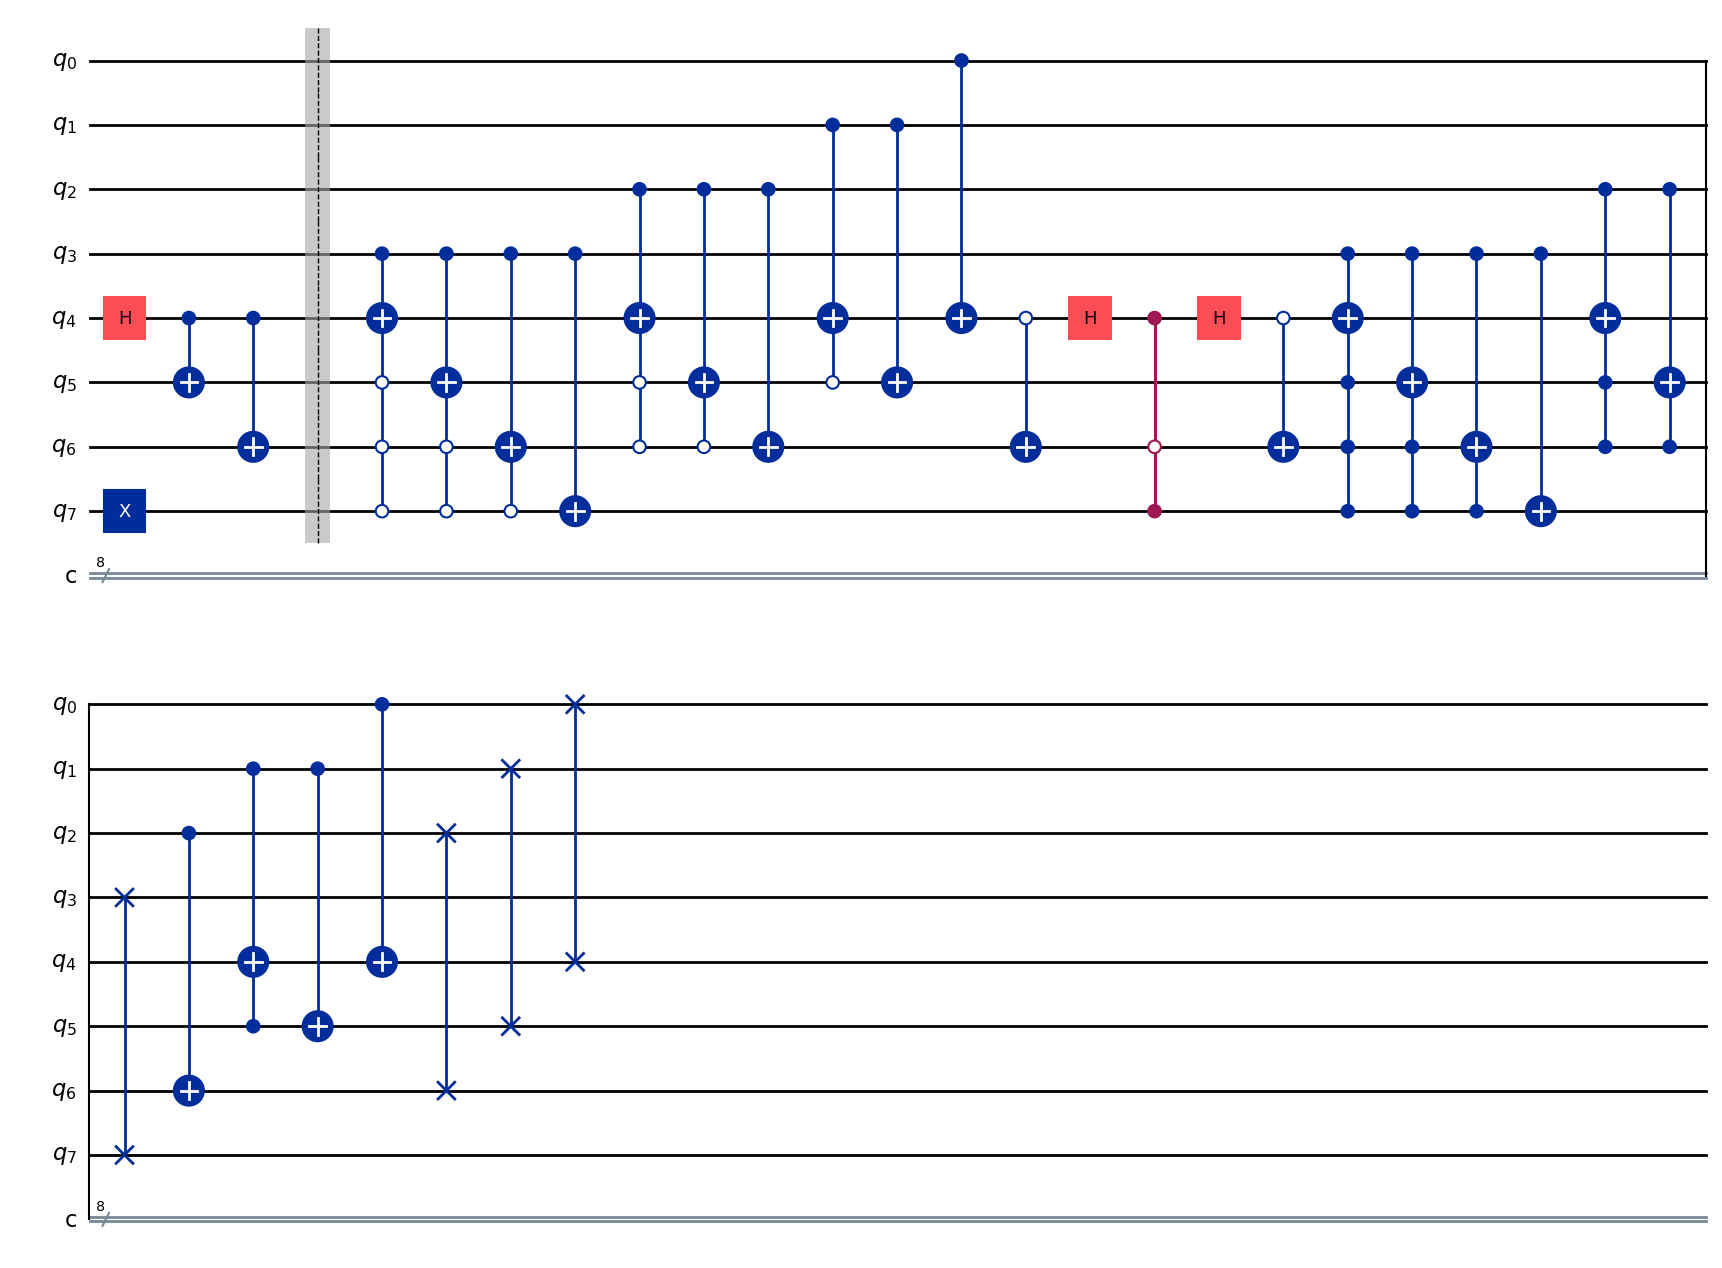

In [383]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
qc.barrier()

# states = [Statevector.from_instruction(qc)]
# print(f"Initial state: {states[0]}")
szegedy_step(qc)
qc.draw(output="mpl")


range(0, 16) dict_keys(['0000']) [np.float64(0.9999999999999998)]
range(0, 16) dict_keys(['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']) [np.float64(3.4125458129276046e-32), np.float64(0.49999999999999756), np.float64(1.9996635249355575e-64), np.float64(1.3028624504410392e-32), np.float64(2.8149136500007232e-65), np.float64(4.474398578955194e-34), np.float64(9.492823772102646e-64), np.float64(2.281114711662248e-34), np.float64(2.2261109359577764e-64), np.float64(8.3707790638507e-33), np.float64(6.608746761918548e-35), np.float64(1.4616058861683773e-32), np.float64(1.3797373035046915e-65), np.float64(1.1137759610835646e-32), np.float64(1.825581312551148e-32), np.float64(0.4999999999999979)]
range(0, 16) dict_keys(['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']) [np.float64(0.49999999999999506), np.float64(2.9438534373105165e-3

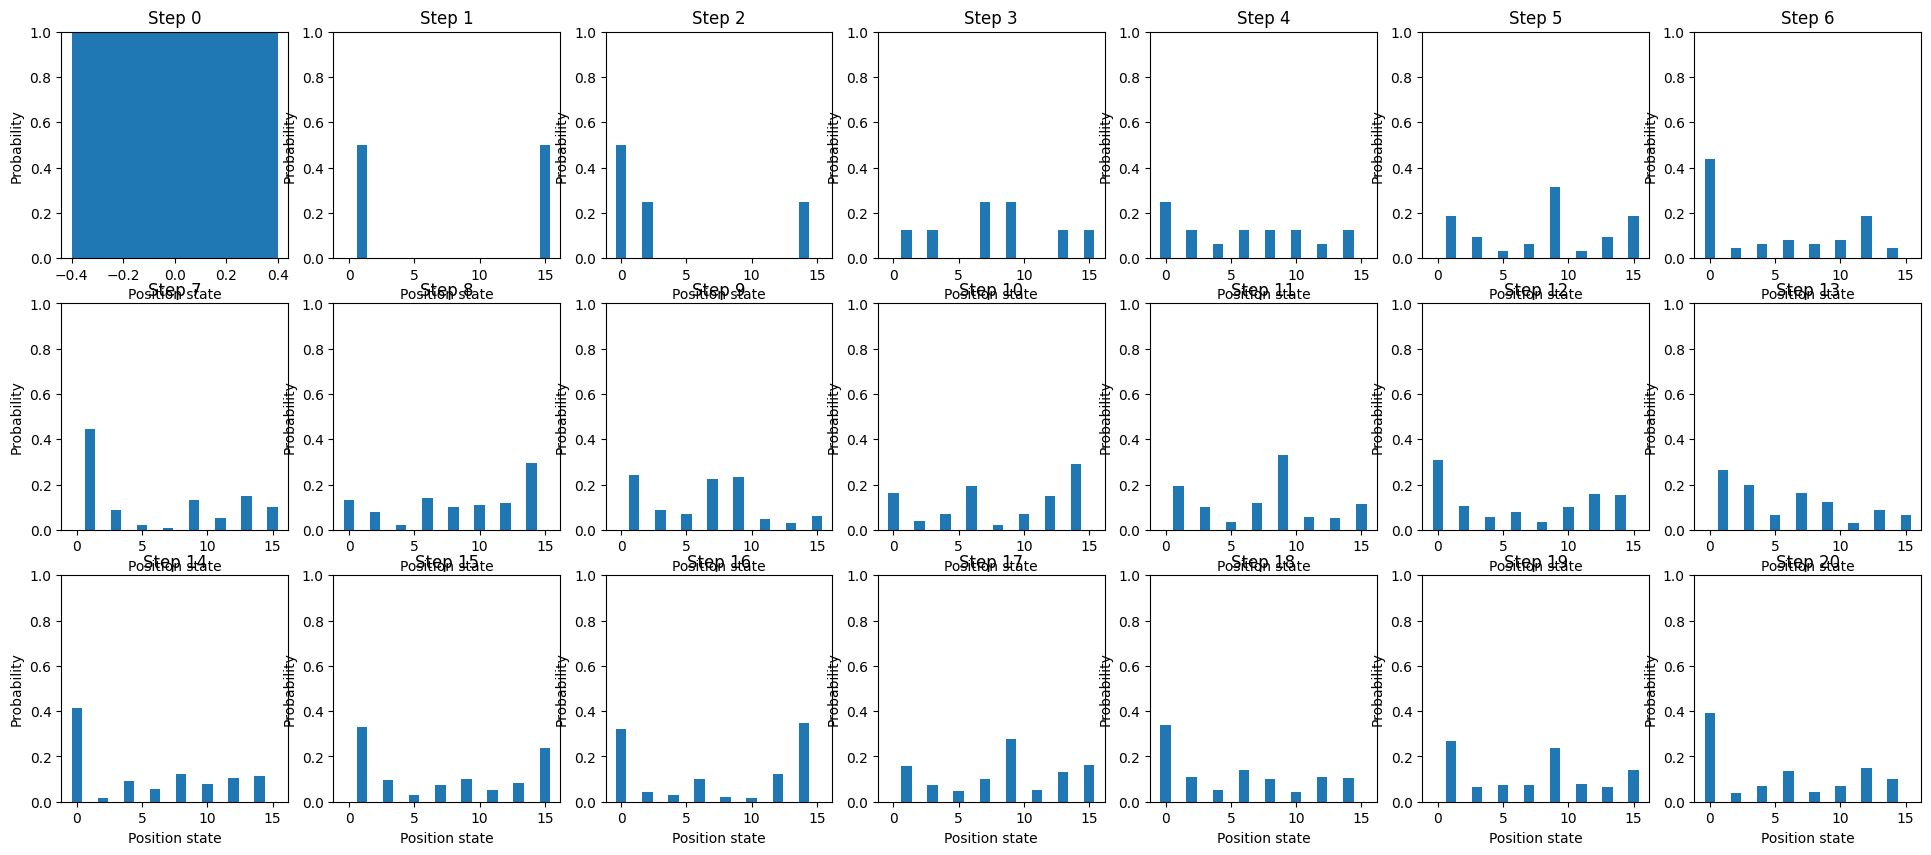

In [384]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 20

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
# qc.barrier()

states = [Statevector.from_instruction(qc)]
szegedy_step(qc)
states.append(Statevector.from_instruction(qc))
for i in range(steps-1):
    qc.h(num_input + 0)
    szegedy_step(qc)
    # print(f"Step {i+1}")
    states.append(Statevector.from_instruction(qc))


# fig, axs = plt.subplots(7, 3, figsize=(24, 50))
fig, axs = plt.subplots(3, 7, figsize=(24, 10))

axs = axs.flatten()
for i, state in enumerate(states):
    probs = state.probabilities_dict()
    
    filtered = {}
    for key, val in probs.items():
        # if val < 0.0001:
        #     continue
        pos = (key[num_input:])
        # print(f"key: {key}, pos: {pos}, val: {val}")
        filtered[pos] = filtered.get(pos, 0) + val
    
    t_filtered = {k[::-1]: v for k, v in filtered.items()}
    
    sorted_keys = sorted(t_filtered.keys(), key=lambda x: int(x, 2))
    sorted_values = [t_filtered[k] for k in sorted_keys]
    
    
    
    print(range(2**num_input), filtered.keys(), sorted_values)
    axs[i].bar(range(len(sorted_values)), sorted_values)
    # axs[i].bar(filtered.keys(), filtered.values())
    axs[i].set_title(f"Step {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Position state")
    axs[i].set_ylabel("Probability")

# plt.tight_layout()
# plt.show()

# qc.draw(output="mpl")



Så man kan se stora tal för en vis step

Text(0, 0.5, 'Probability')

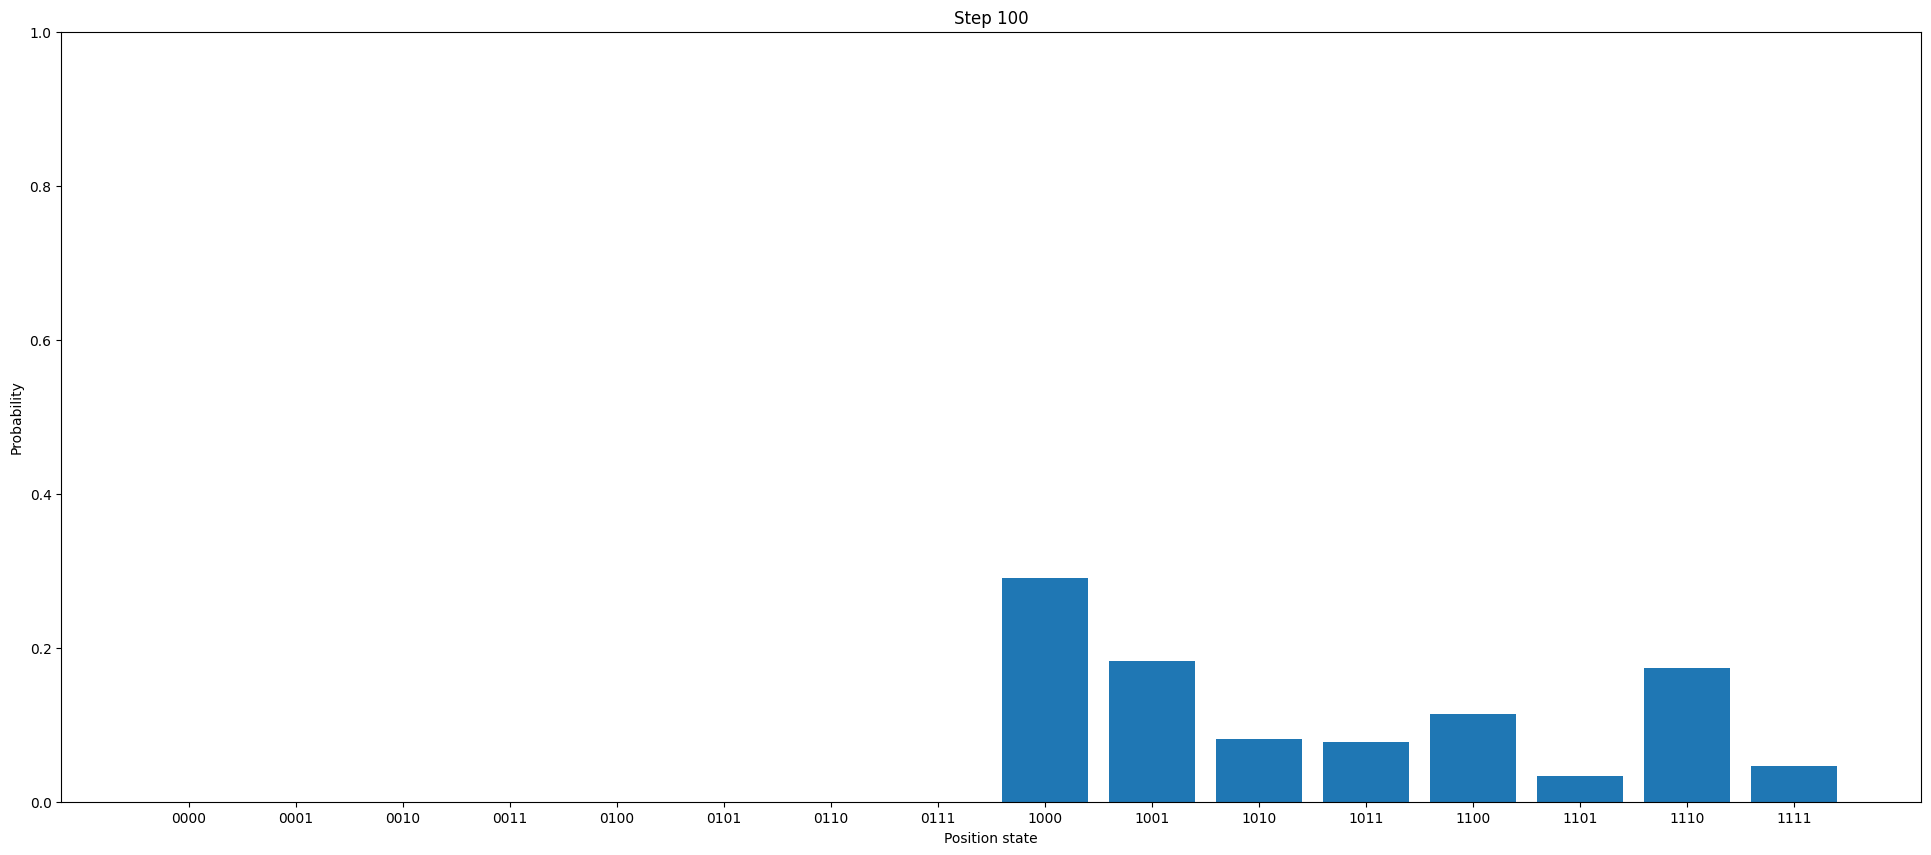

In [385]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 100

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
# qc.barrier()

szegedy_step(qc)
for _ in range(steps-1):
    qc.h(num_input + 0)
    szegedy_step(qc)

state = Statevector.from_instruction(qc)


fig, axs = plt.subplots(1, 1, figsize=(24, 10))

probs = state.probabilities_dict()
filtered = {}
for key, val in probs.items():
    pos = key[:num_input]
    filtered[pos] = filtered.get(pos, 0) + val

axs.bar(filtered.keys(), filtered.values())
axs.set_title(f"Step {steps}")
axs.set_ylim(0, 1)
axs.set_xlabel("Position state")
axs.set_ylabel("Probability")


